### 作業
請嘗試使用 flip (左右翻轉) 來做 augmentation 以降低人臉關鍵點檢測的 loss

Note: 圖像 flip 之後，groundtruth 的關鍵點也要跟著 flip 哦




### 範例
接下來的程式碼會示範如何定義一個簡單的 CNN model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# 使用 colab 環境的同學請執行以下程式碼
# %tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
# import tensorflow as tf
# print(tf.__version__)

# import os
# from google.colab import drive 
# drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# %cd 'gdrive/My Drive'
# os.system("mkdir cupoy_cv_part4") # 可以自己改路徑
# %cd cupoy_cv_part4 # 可以自己改路徑

In [2]:
# 讀取資料集以及做前處理的函數
def load_data(dirname):
    # 讀取 csv 文件
    data = pd.read_csv(dirname)
    # 過濾有缺失值的 row
    data = data.dropna()

    # 將圖片像素值讀取為 numpy array 的形態
    data['Image'] = data['Image'].apply(lambda img: np.fromstring(img, sep=' ')).values 

    # 單獨把圖像 array 抽取出來
    imgs = np.vstack(data['Image'].values)/255
    # reshape 為 96 x 96
    imgs = imgs.reshape(data.shape[0], 96, 96)
    # 轉換為 float
    imgs = imgs.astype(np.float32)
    
    # 提取坐標的部分
    points = data[data.columns[:-1]].values

    # 轉換為 float
    points = points.astype(np.float32)

    # normalize 坐標值到 [-0.5, 0.5]
    points = points/96 - 0.5
    
    return imgs, points

In [3]:
# 讀取資料
imgs_train, points_train = load_data(dirname = 'training.csv')
print("圖像資料:", imgs_train.shape, "\n關鍵點資料:", points_train.shape)

圖像資料: (2140, 96, 96) 
關鍵點資料: (2140, 30)


In [4]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

Using TensorFlow backend.


In [5]:
# 回傳定義好的 model 的函數
def get_model():
    # 定義人臉關鍵點檢測網路
    model = Sequential()

    # 定義神經網路的輸入
    model.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(96, 96, 1)))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    # 最後輸出 30 維的向量，也就是 15 個關鍵點的值
    model.add(Dense(30))
    return model

In [6]:
model = get_model()
# 配置 loss funtion 和 optimizer
model.compile(loss='mean_squared_error', optimizer='adam')






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [7]:
# 印出網路結構
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)        

In [8]:
from keras.callbacks import ModelCheckpoint, History
# model checkpoint 
checkpoint = ModelCheckpoint('best_weights.h5', verbose=1, save_best_only=True)
hist = History()

In [9]:
# training the model
hist_model = model.fit(imgs_train.reshape(-1, 96, 96, 1), 
                       points_train, 
                       validation_split=0.2, batch_size=64, callbacks=[checkpoint, hist],
                       shuffle=True, epochs=150, verbose=1)
# save the model weights
model.save_weights('weights.h5')
# save the model
model.save('model.h5')




Train on 1712 samples, validate on 428 samples
Epoch 1/150





1712/1712 [==============================] - 7s 4ms/step - loss: 0.0070 - val_loss: 0.0023

Epoch 00001: val_loss improved from inf to 0.00226, saving model to best_weights.h5
Epoch 2/150
1712/1712 [==============================] - 6s 3ms/step - loss: 0.0020 - val_loss: 0.0019

Epoch 00002: val_loss improved from 0.00226 to 0.00192, saving model to best_weights.h5
Epoch 3/150
1712/1712 [==============================] - 6s 3ms/step - loss: 0.0014 - val_loss: 0.0019

Epoch 00003: val_loss improved from 0.00192 to 0.00189, saving model to best_weights.h5
Epoch 4/150
1712/1712 [==============================] - 6s 4ms/step - loss: 0.0012 - val_loss: 0.0019

Epoch 00004: val_loss improved from 0.00189 to 0.00189, saving model to best_weights.h5
Epoch 5/150
1712/1712 [==============================] - 6s 4ms/step - loss: 0.0011 - val_loss: 0.0019

Epoch 00005: val_loss improved from 0.00189 to 0.00187, saving model to best_

1712/1712 [==============================] - 6s 3ms/step - loss: 2.3598e-04 - val_loss: 8.5913e-04

Epoch 00037: val_loss did not improve from 0.00081
Epoch 38/150
1712/1712 [==============================] - 6s 3ms/step - loss: 2.3156e-04 - val_loss: 7.7587e-04

Epoch 00038: val_loss improved from 0.00081 to 0.00078, saving model to best_weights.h5
Epoch 39/150
1712/1712 [==============================] - 6s 3ms/step - loss: 2.2719e-04 - val_loss: 7.9703e-04

Epoch 00039: val_loss did not improve from 0.00078
Epoch 40/150
1712/1712 [==============================] - 6s 3ms/step - loss: 2.3007e-04 - val_loss: 7.9841e-04

Epoch 00040: val_loss did not improve from 0.00078
Epoch 41/150
1712/1712 [==============================] - 6s 3ms/step - loss: 2.1828e-04 - val_loss: 8.0181e-04

Epoch 00041: val_loss did not improve from 0.00078
Epoch 42/150
1712/1712 [==============================] - 6s 3ms/step - loss: 2.1401e-04 - val_loss: 7.7239e-04

Epoch 00042: val_loss improved from 0.00078

1712/1712 [==============================] - 6s 4ms/step - loss: 1.3337e-04 - val_loss: 7.5219e-04

Epoch 00086: val_loss did not improve from 0.00075
Epoch 87/150
1712/1712 [==============================] - 6s 3ms/step - loss: 1.3450e-04 - val_loss: 7.5487e-04

Epoch 00087: val_loss did not improve from 0.00075
Epoch 88/150
1712/1712 [==============================] - 6s 3ms/step - loss: 1.3838e-04 - val_loss: 7.8949e-04

Epoch 00088: val_loss did not improve from 0.00075
Epoch 89/150
1712/1712 [==============================] - 6s 3ms/step - loss: 1.3314e-04 - val_loss: 7.7391e-04

Epoch 00089: val_loss did not improve from 0.00075
Epoch 90/150
1712/1712 [==============================] - 6s 3ms/step - loss: 1.2909e-04 - val_loss: 7.7367e-04

Epoch 00090: val_loss did not improve from 0.00075
Epoch 91/150
1712/1712 [==============================] - 6s 3ms/step - loss: 1.2926e-04 - val_loss: 7.9275e-04

Epoch 00091: val_loss did not improve from 0.00075
Epoch 92/150
1712/1712 [=====

1712/1712 [==============================] - 6s 3ms/step - loss: 9.1974e-05 - val_loss: 7.8517e-04

Epoch 00135: val_loss did not improve from 0.00074
Epoch 136/150
1712/1712 [==============================] - 6s 3ms/step - loss: 9.4469e-05 - val_loss: 7.7882e-04

Epoch 00136: val_loss did not improve from 0.00074
Epoch 137/150
1712/1712 [==============================] - 6s 3ms/step - loss: 9.4762e-05 - val_loss: 8.1560e-04

Epoch 00137: val_loss did not improve from 0.00074
Epoch 138/150
1712/1712 [==============================] - 6s 3ms/step - loss: 9.3406e-05 - val_loss: 7.7686e-04

Epoch 00138: val_loss did not improve from 0.00074
Epoch 139/150
1712/1712 [==============================] - 6s 3ms/step - loss: 9.2292e-05 - val_loss: 7.7356e-04

Epoch 00139: val_loss did not improve from 0.00074
Epoch 140/150
1712/1712 [==============================] - 6s 3ms/step - loss: 9.4933e-05 - val_loss: 7.6053e-04

Epoch 00140: val_loss did not improve from 0.00074
Epoch 141/150
1712/1712 

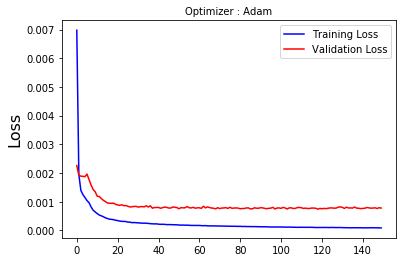

In [10]:
# loss 值的圖
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist_model.history['loss'], color='b', label='Training Loss')
plt.plot(hist_model.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

### 觀察 model 在 testing 上的結果

In [11]:
# 讀取測試資料集
imgs_test, _ = load_data(dirname = 'test.csv')

In [12]:
# 在灰階圖像上畫關鍵點的函數
def plot_keypoints(img, points):
    plt.imshow(img, cmap='gray')
    for i in range(0,30,2):
        plt.scatter((points[i] + 0.5)*96, (points[i+1]+0.5)*96, color='red')

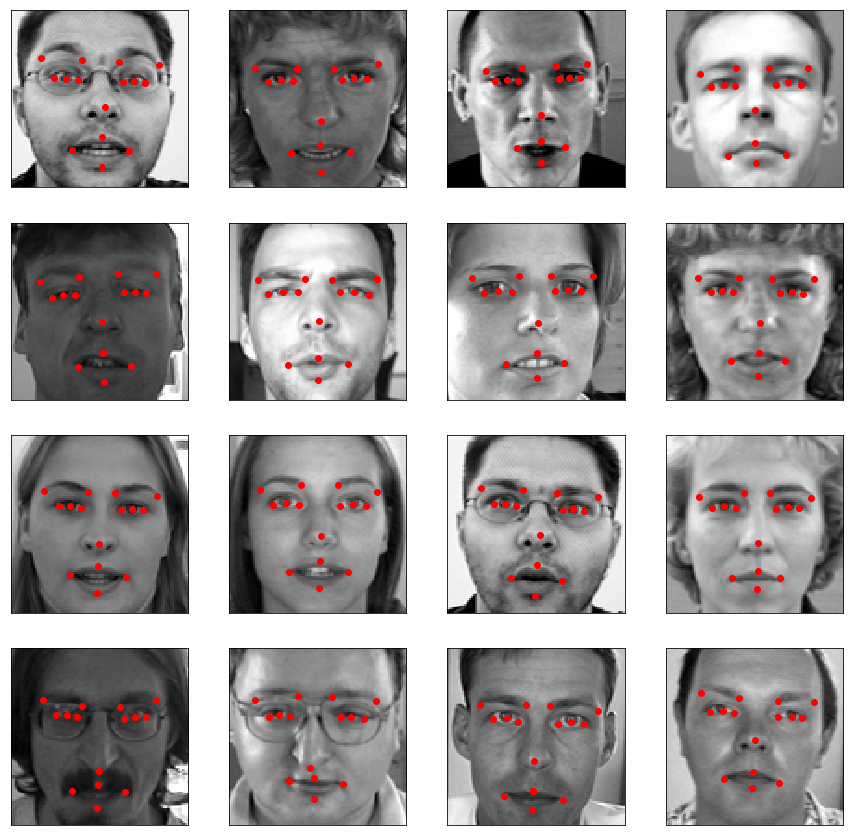

In [13]:
fig = plt.figure(figsize=(15,15))
# 在測試集圖片上用剛剛訓練好的模型做關鍵點的預測
points_test = model.predict(imgs_test.reshape(imgs_test.shape[0], 96, 96, 1))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_keypoints(imgs_test[i], np.squeeze(points_test[i]))

目前為止，大致可以觀察到，直接使用簡單的模型以及訓練方式在這組數據上應該可以在訓練集和測試集上都得到一個還不錯的結果，說明這組資料其實不會很難。

In [14]:
model_with_augment = get_model()
model_with_augment.compile(loss='mean_squared_error', optimizer='adam')

In [16]:
# import image augmentation
from imgaug import augmenters as iaa

# 水平翻轉機率設成 1，這裡我將所有訓練資料集翻轉，將其當作新的資料進行訓練
flipper = iaa.Fliplr(1.0) 
imgs_train_aug = flipper(images=imgs_train)
# change the x coordinate of the key points
points_train[:, 0::2] = -points_train[:, 0::2]

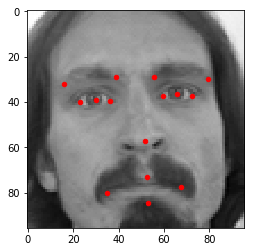

In [17]:
sample_img, sample_points = imgs_train_aug[0], points_train[0]
x = (sample_points[0::2] + 0.5) * 96
y = (sample_points[1::2] + 0.5) * 96
plt.imshow(sample_img, cmap='gray')
plt.scatter(x, y, s=20, c='r')
plt.show()

In [19]:
model_with_augment.load_weights("best_weights.h5") # 載入之前 train 好的權重
# training the model
hist_aug_model = model_with_augment.fit(imgs_train_aug.reshape(-1, 96, 96, 1), 
                                        points_train, 
                                        validation_split=0.2, batch_size=64, callbacks=[checkpoint, hist],
                                        shuffle=True, epochs=75, verbose=1)
# save the model weights
model_with_augment.save_weights('aug_weights.h5')
# save the model
model_with_augment.save('aug_model.h5')

Train on 1712 samples, validate on 428 samples
Epoch 1/75
1712/1712 [==============================] - 6s 4ms/step - loss: 0.0170 - val_loss: 0.0024

Epoch 00001: val_loss did not improve from 0.00074
Epoch 2/75
1712/1712 [==============================] - 6s 4ms/step - loss: 0.0028 - val_loss: 0.0019

Epoch 00002: val_loss did not improve from 0.00074
Epoch 3/75
1712/1712 [==============================] - 6s 4ms/step - loss: 0.0019 - val_loss: 0.0020

Epoch 00003: val_loss did not improve from 0.00074
Epoch 4/75
1712/1712 [==============================] - 6s 3ms/step - loss: 0.0015 - val_loss: 0.0018

Epoch 00004: val_loss did not improve from 0.00074
Epoch 5/75
1712/1712 [==============================] - 6s 4ms/step - loss: 0.0014 - val_loss: 0.0018

Epoch 00005: val_loss did not improve from 0.00074
Epoch 6/75
1712/1712 [==============================] - 6s 3ms/step - loss: 0.0012 - val_loss: 0.0019

Epoch 00006: val_loss did not improve from 0.00074
Epoch 7/75
1712/1712 [=======

1712/1712 [==============================] - 6s 3ms/step - loss: 2.6568e-04 - val_loss: 7.3132e-04

Epoch 00051: val_loss did not improve from 0.00071
Epoch 52/75
1712/1712 [==============================] - 6s 3ms/step - loss: 2.5521e-04 - val_loss: 7.2315e-04

Epoch 00052: val_loss did not improve from 0.00071
Epoch 53/75
1712/1712 [==============================] - 6s 4ms/step - loss: 2.5231e-04 - val_loss: 7.0576e-04

Epoch 00053: val_loss improved from 0.00071 to 0.00071, saving model to best_weights.h5
Epoch 54/75
1712/1712 [==============================] - 6s 3ms/step - loss: 2.5522e-04 - val_loss: 7.2148e-04

Epoch 00054: val_loss did not improve from 0.00071
Epoch 55/75
1712/1712 [==============================] - 6s 3ms/step - loss: 2.4763e-04 - val_loss: 7.3360e-04

Epoch 00055: val_loss did not improve from 0.00071
Epoch 56/75
1712/1712 [==============================] - 6s 4ms/step - loss: 2.5202e-04 - val_loss: 7.5989e-04

Epoch 00056: val_loss did not improve from 0.000

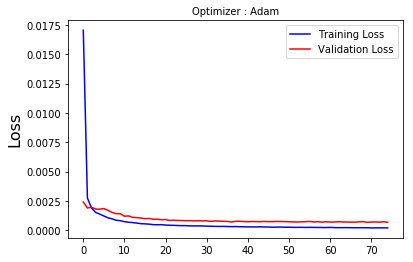

In [20]:
# loss 值的圖
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist_aug_model.history['loss'], color='b', label='Training Loss')
plt.plot(hist_aug_model.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

* 從loss圖可以看出，加入水平翻轉後，loss 確實有些微的降低，也使得訓練集與驗證集的 loss 更加接近，降低模型的 overfitting
* 因為模型有載入之前訓練好的參數，其實可以不用訓練這麼多次，這些水平翻轉後的圖片主要是去微調模型的參數，降低模型的 overfitting